In [1]:
%reset -f
%matplotlib inline

In [2]:
import pyross
import numpy as np
import matplotlib.pyplot as plt

# Introduction: Forecast for SEAI5R model with stochastic parameters

In this notebook, we consider the SEAI5R model with UK age structure and contact matrix. 

Based on the results of inference, we calculate a forecast (including 90/10 percentiles), both with and without interventions.

### Load age structure, contact matrix, and results from inference

In [3]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
print(N)
fi = Ni/N

64111602.0


In [4]:
# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = CH0[i,:]*Ni0[i]
    CW0[i,:] = CW0[i,:]*Ni0[i]
    CS0[i,:] = CS0[i,:]*Ni0[i]
    CO0[i,:] = CO0[i,:]*Ni0[i]


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )/Ni[i]
        
C = CH + CW + CS +CO
        
    
# NOTE: For the inference all population numbers were divided by 5e2. We here assume 
# that this does not change the result of the inference!! 
N = N #/ 5e2
Ni = Ni#/5e2

In [5]:
pre_intervention_traj = np.load('../inference/pre_intervention_traj_SEAI5R.npy')*5e2
print(np.shape(pre_intervention_traj))

'''
fig,ax = plt.subplots(1,1,figsize=(10,6))
for i,e in enumerate(pre_intervention_traj.T):
    ax.plot(e)
plt.show(fig)
plt.close(fig)
''';

(21, 36)


Note that for the plots below, we do not show the actual trajectory used for the inference, but a newly generated "reference trajectory". Since in the scales below the time interval where inference is done (up to time 20 days) is not really resolvable, this does not really change the plots.

In [6]:
# Generate longer trajectory, which is used as "reference trajectory"

beta  = 0.04         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 


# initial conditions
E0   = np.array([10]*M)
A0   = np.array([10]*M)
Ia0  = np.array([10]*M)# each age group has asymptomatic infectives
Is0  = np.array([10]*M)# and also symptomatic infectives
Ih0  = np.array([10]*M)
Ic0  = np.array([10]*M)
Im0  = np.array([2]*M)
R0   = np.zeros(M)
S0   = Ni.copy() - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.stochastic.SEAI5R(parameters, M, Ni.copy())
#print(Ni)

# the contact structure is independent of time 
def contactMatrix(t):
    return C

# start simulation
Tf_reference=600;  Nf_reference=Tf_reference+1 
data_reference=model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, contactMatrix, Tf_reference, Nf_reference,
                   method='tau-leaping',
                             )

#print(data_reference['X'][30])
'''
fig,ax = plt.subplots(1,1,figsize=(10,6))
for i,e in enumerate(data_reference['X'].T):
    ax.plot(e)
plt.show(fig)
plt.close(fig)
''';

Now we load the means + covariance matrix obtained from inference

In [7]:
means = np.load('../inference/optimal_model_param_SEAI5R.npy')
alpha, beta, gIa, gIs, gE, gA = means

hess = np.load('../inference/hessian_SEAI5R.npy')
cov = np.linalg.inv(hess)

# these parameters we assume exact
gIh   = 1/14
gIc   = 1/14
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa    = 0*np.ones(M)      # arrival of new susceptibles


# take the values at time 20 days of the reference trajectory as initial condition for the forecast
index_initial_condition = 20
S_0 = data_reference['X'][index_initial_condition,:M]
E_0 = data_reference['X'][index_initial_condition,M:2*M]
A_0 = data_reference['X'][index_initial_condition,2*M:3*M]
Ia_0 = data_reference['X'][index_initial_condition,3*M:4*M]
Is_0 = data_reference['X'][index_initial_condition,4*M:5*M]
Ih_0 = data_reference['X'][index_initial_condition,5*M:6*M]
Ic_0 = data_reference['X'][index_initial_condition,6*M:7*M]
Im_0 = data_reference['X'][index_initial_condition,7*M:8*M]
Ni_0 = data_reference['X'][index_initial_condition,8*M:]

## Forecast without interventions

In [8]:
# duration of simulation
Tf_forecast=580;  Nf_forecast=Tf_forecast+1;  


# the contact structure is independent of time 
def contactMatrix(t):
    return C

# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 
              'hh':hh, 'cc':cc, 'mm':mm,
             'cov':cov} 

In [9]:
N_samples = 500

output_trajectories = np.zeros([N_samples,M*9,Nf_forecast],dtype=float)

sample_parameters = np.random.multivariate_normal(means, cov, N_samples)



for i in range(N_samples):
    print(i,end='\r')
    while (sample_parameters[i] < 0).any():
        sample_parameters[i] = np.random.multivariate_normal(means, cov)
    #
    parameters = {'alpha':sample_parameters[i,0],
                        'beta':sample_parameters[i,1],
                        'gIa':sample_parameters[i,2],
                        'gIs':sample_parameters[i,3],
                        'gE':sample_parameters[i,4],
                        'gA':sample_parameters[i,5],
                        'gIh':gIh,'gIc':gIc,
                        'fsa':fsa,'fh':fh,
                        'sa':sa,'hh':hh,
                        'mm':mm,'cc':cc
                          }
    #model = pyross.stochastic.SEAI5R(parameters, M, np.array( Ni.copy(),dtype=float))
    model = pyross.deterministic.SEAI5R(parameters, M, np.array( Ni.copy(),dtype=float))
    result = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0,
                        #events =events,
                        #         contactMatrices=contactMatrices,
                        contactMatrix=contactMatrix,
                        Tf=Tf_forecast, Nf=Nf_forecast,
                                      #verbose=True,
                       # method='tau-leaping'
                       ) 
    output_trajectories[i] = result['X'].T

In [10]:
trajectories_forecast = output_trajectories
t_forecast = result['t'] + 20

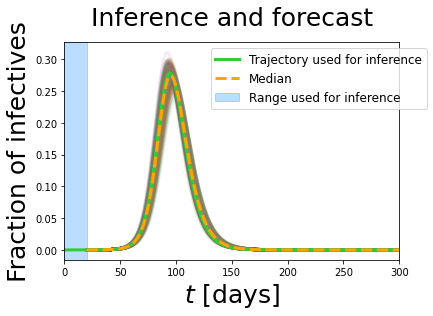

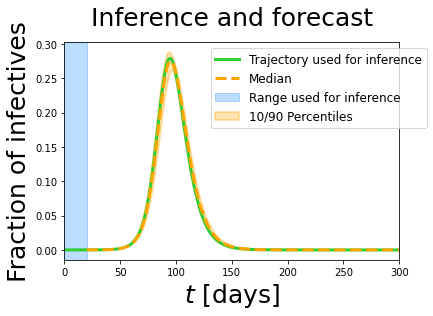

In [15]:
# Plot sum of A, Ia, Is populations
Tf_inference = 20

fontsize=25

ylabel=r'Fraction of infectives'

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,2*M:5*M,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)

cur_trajectory_underlying = np.sum( data_reference['X'][:,2*M:5*M] ,axis=1 )

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Inference and forecast',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    ax.plot(t_forecast,e/N,
            alpha=0.15,
            lw=3,
           )
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
ax.set_xlim(0,np.max(t_forecast))
ax.set_xlim(0,300)
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.1,1),
          fontsize=12)
plt.show(fig)
fig.savefig('SEAI5R_UK_inference_forecasting_0.png',bbox_inches='tight',dpi=100)
fig.savefig('SEAI5R_UK_inference_forecasting_0.jpg',bbox_inches='tight',dpi=300)
plt.close(fig)







# Plot sum of A, Ia, Is populations
Tf_inference = 20

fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,2*M:5*M,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


cur_trajectory_underlying = np.sum( data_reference['X'][:,2*M:5*M] ,axis=1 )

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Inference and forecast',
             y=1.05,
            fontsize=fontsize)
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
# remove comments to plot percentiles

ax.fill_between(t_forecast,percentiles_lower/N,
        percentiles_upper/N,
                alpha=0.3,
        lw=2,
        label=r'10/90 Percentiles',
        color='orange',
       )

ax.set_xlim(0,np.max(t_forecast))
ax.set_xlim(0,300)
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.1,1),
          fontsize=12)
plt.show(fig)
fig.savefig('SEAI5R_UK_inference_forecasting_1.png',bbox_inches='tight',dpi=100)
fig.savefig('SEAI5R_UK_inference_forecasting_1.jpg',bbox_inches='tight',dpi=300)
plt.close(fig)

## Forecast with interventions

In [16]:
output_trajectories_2 = np.zeros([N_samples,M*9,Nf_forecast],dtype=float)

sample_parameters = np.random.multivariate_normal(means, cov, N_samples)

beginning_lockdown_1 = 50
end_lockdown_1 = 150
beginning_lockdown_2 = 180
end_lockdown_2 = 250
def contactMatrix2(t):
    if t < beginning_lockdown_1: #or t > 150) and (t < 200):
        return C
    elif t < end_lockdown_1:
        return CH
    elif t < beginning_lockdown_2:
        return C
    elif t < end_lockdown_2:
        return CH
    else:
        return C

for i in range(N_samples):
    print(i,end='\r')
    while (sample_parameters[i] < 0).any():
        sample_parameters[i] = np.random.multivariate_normal(means, cov)
    #
    parameters = {'alpha':sample_parameters[i,0],
                        'beta':sample_parameters[i,1],
                        'gIa':sample_parameters[i,2],
                        'gIs':sample_parameters[i,3],
                        'gE':sample_parameters[i,4],
                        'gA':sample_parameters[i,5],
                        'gIh':gIh,'gIc':gIc,
                        'fsa':fsa,'fh':fh,
                        'sa':sa,'hh':hh,
                        'mm':mm,'cc':cc
                          }
    #model = pyross.stochastic.SEAI5R(parameters, M, np.array( Ni.copy(),dtype=float))
    model = pyross.deterministic.SEAI5R(parameters, M, np.array( Ni.copy(),dtype=float))
    result = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0,
                        #events =events,
                        #         contactMatrices=contactMatrices,
                        contactMatrix=contactMatrix2,
                        Tf=Tf_forecast, Nf=Nf_forecast,
                                      #verbose=True,
                        #method='tau-leaping'
                       ) 
    output_trajectories_2[i] = result['X'].T

In [17]:
trajectories_forecast = output_trajectories_2 

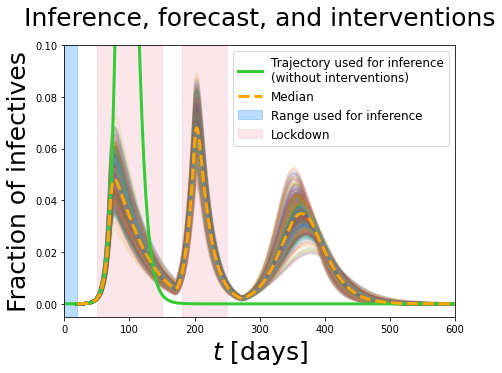

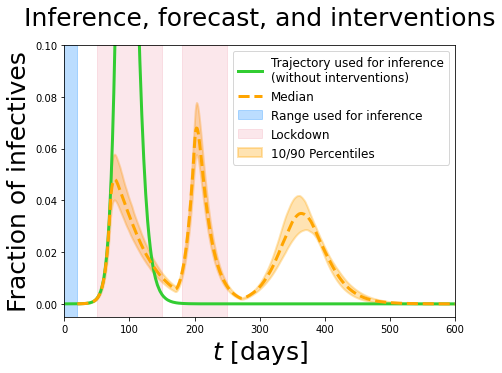

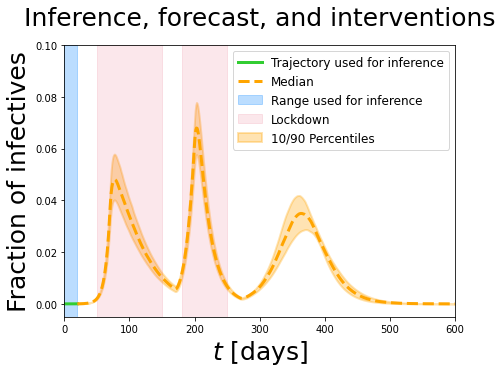

In [21]:
# Plot sum of A, Ia, Is populations
Tf_inference = 20

fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,2*M:5*M,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)



#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.axvspan(beginning_lockdown_1,end_lockdown_1, 
           label='Lockdown',
           alpha=0.1, color='crimson')
ax.axvspan(beginning_lockdown_2,end_lockdown_2, 
 #          label='Lockdown',
           alpha=0.1, color='crimson')

ax.set_title(r'Inference, forecast, and interventions',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    ax.plot(t_forecast,e/N,
            alpha=0.15,
            lw=3,
           )
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference\n(without interventions)')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.,1),
          fontsize=12)
ax.set_ylim(-0.005,0.1)
plt.show(fig)
fig.savefig('SEAI5R_UK_inference_forecasting_2.png',bbox_inches='tight',dpi=100)
fig.savefig('SEAI5R_UK_inference_forecasting_2.jpg',bbox_inches='tight',dpi=300)
plt.close(fig)









fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.axvspan(beginning_lockdown_1,end_lockdown_1, 
           label='Lockdown',
           alpha=0.1, color='crimson')
ax.axvspan(beginning_lockdown_2,end_lockdown_2, 
 #          label='Lockdown',
           alpha=0.1, color='crimson')



ax.set_title(r'Inference, forecast, and interventions',
             y=1.05,
            fontsize=fontsize)
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference\n(without interventions)')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
ax.fill_between(t_forecast,percentiles_lower/N,
        percentiles_upper/N,
                alpha=0.3,
        lw=2,
        label=r'10/90 Percentiles',
        color='orange',
       )

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.,1),
          fontsize=12)
ax.set_ylim(-0.005,0.1)
plt.show(fig)
fig.savefig('SEAI5R_UK_inference_forecasting_3.png',bbox_inches='tight',dpi=100)
fig.savefig('SEAI5R_UK_inference_forecasting_3.jpg',bbox_inches='tight',dpi=300)
plt.close(fig)






fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.axvspan(beginning_lockdown_1,end_lockdown_1, 
           label='Lockdown',
           alpha=0.1, color='crimson')
ax.axvspan(beginning_lockdown_2,end_lockdown_2, 
 #          label='Lockdown',
           alpha=0.1, color='crimson')



ax.set_title(r'Inference, forecast, and interventions',
             y=1.05,
            fontsize=fontsize)
ax.plot(cur_trajectory_underlying[:21]/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')
ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
ax.fill_between(t_forecast,percentiles_lower/N,
        percentiles_upper/N,
                alpha=0.3,
        lw=2,
        label=r'10/90 Percentiles',
        color='orange',
       )

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.,1),
          fontsize=12)
ax.set_ylim(-0.005,0.1)
plt.show(fig)
fig.savefig('SEAI5R_UK_inference_forecasting_4.png',bbox_inches='tight',dpi=100)
fig.savefig('SEAI5R_UK_inference_forecasting_4.jpg',bbox_inches='tight',dpi=300)
plt.close(fig)